# Explanatory Detection of Online Sexism (EDOS Classification)

No need to add anything such as glove, I uploaded in drive publicly and accessed from link.

### Task - A (Binary Sexism Classification: Not Sexism & Sexism)

In [46]:

import pandas as pd
import numpy as np
import seaborn as sns
import re
import gdown

from keras.metrics import Precision, Recall
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam

import os
import shutil
import re
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding, Bidirectional
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
import torchtext

from nltk.corpus import stopwords
import string
import os
from collections import Counter
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize

In [47]:
# read dataset from a public Google Drive File

file_link = 'https://drive.google.com/file/d/107gOBmxc7yFTUWHHHnnCjnPwBY2yu2f-/view?usp=drive_link'

# get the id part of the file
id = file_link.split("/")[-2]

# creating a new link using the id for better readability of csv file in pandas
new_link = f'https://drive.google.com/uc?id={id}'
df = pd.read_csv(new_link)

# let's look at the first few instances
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [48]:
df.shape

(14000, 5)

<Axes: xlabel='label_sexist', ylabel='count'>

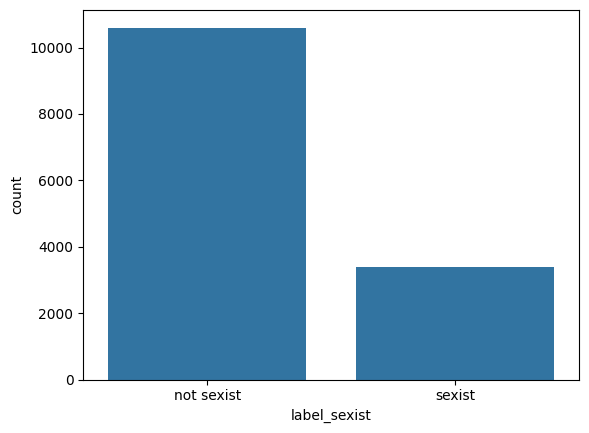

In [49]:
sns.countplot(x='label_sexist', data=df)

In [50]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [54]:
df['text'] = df['text'].apply(preprocess_text)
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,damn writing pretty chaotic,not sexist,none,none
1,sexism2022_english-2367,yeah apparently bunch misogynistic virgins one...,not sexist,none,none
2,sexism2022_english-3073,fuck woman still mp,not sexist,none,none
3,sexism2022_english-14895,understand know right time know enough money w...,not sexist,none,none
4,sexism2022_english-4118,surprized stop rape women,not sexist,none,none


In [55]:
# Function to load GloVe embeddings from Google Drive file ID
def load_glove_embeddings_from_drive(file_id):
    url = f'https://drive.google.com/uc?id={file_id}'
    output_path = 'a2_glove.6B.100d.txt'
    gdown.download(url, output_path, quiet=False)
    return output_path

# Provide the file ID of the GloVe embeddings file hosted on Google Drive
file_id = '1v13qqznplbTn1n95yVKxqNQe0JGCfdTq'  # Replace with the actual file ID

# Load GloVe embeddings from the Google Drive file ID
glove_embeddings_file = load_glove_embeddings_from_drive(file_id)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_embeddings_file)


Downloading...
From (original): https://drive.google.com/uc?id=1v13qqznplbTn1n95yVKxqNQe0JGCfdTq
From (redirected): https://drive.google.com/uc?id=1v13qqznplbTn1n95yVKxqNQe0JGCfdTq&confirm=t&uuid=68bd43f4-5ab5-4661-b9f2-513c185201db
To: /content/a2_glove.6B.100d.txt
100%|██████████| 347M/347M [00:10<00:00, 34.5MB/s]


In [56]:
X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [57]:
y = df['label_sexist']
y = np.array(list(map(lambda x: 0 if x=="not sexist" else 1, y)))

In [58]:
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,damn writing pretty chaotic,not sexist,none,none
1,sexism2022_english-2367,yeah apparently bunch misogynistic virgins one...,not sexist,none,none
2,sexism2022_english-3073,fuck woman still mp,not sexist,none,none
3,sexism2022_english-14895,understand know right time know enough money w...,not sexist,none,none
4,sexism2022_english-4118,surprized stop rape women,not sexist,none,none


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [60]:
maxlen = 35
word_to_index = {word: i + 1 for i, word in enumerate(glove_embeddings.keys())}

embedding_dim = len(next(iter(glove_embeddings.values())))
vocab_size = len(word_to_index) + 1  # Add 1 for unknown words
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Example LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 100)           40000100  
                                                                 
 bidirectional_4 (Bidirecti  (None, 35, 256)           234496    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 40399206 (154.11 MB)
Trainable params: 3

In [61]:
def tokenizer(text):
    return word_tokenize(text)

# Convert text data to sequences of word indices

X_train_indices = [[word_to_index.get(word, 0) for word in tokenizer(sentence)] for sentence in X_train]
X_test_indices = [[word_to_index.get(word, 0) for word in tokenizer(sentence)] for sentence in X_test]

# Pad sequences to have the same length
max_len = max(len(seq) for seq in X_train_indices + X_test_indices)
X_train_indices = pad_sequences(X_train_indices, maxlen=max_len)
X_test_indices = pad_sequences(X_test_indices, maxlen=max_len)

# Convert output labels to one-hot encoding
num_classes = len(set(y))
Y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_indices, Y_train_onehot,
    validation_data=(X_test_indices, Y_test_onehot),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/1000
175/175 [==============================] - 68s 34ms/step - loss: 0.5015 - accuracy: 0.7674 - precision_2: 0.7674 - recall_2: 0.7674 - val_loss: 0.4991 - val_accuracy: 0.7639 - val_precision_2: 0.7639 - val_recall_2: 0.7639
Epoch 2/1000
175/175 [==============================] - 2s 14ms/step - loss: 0.4294 - accuracy: 0.8107 - precision_2: 0.8107 - recall_2: 0.8107 - val_loss: 0.4231 - val_accuracy: 0.8132 - val_precision_2: 0.8132 - val_recall_2: 0.8132
Epoch 3/1000
175/175 [==============================] - 2s 14ms/step - loss: 0.3892 - accuracy: 0.8346 - precision_2: 0.8346 - recall_2: 0.8346 - val_loss: 0.4221 - val_accuracy: 0.8143 - val_precision_2: 0.8143 - val_recall_2: 0.8143
Epoch 4/1000
175/175 [==============================] - 2s 14ms/step - loss: 0.3717 - accuracy: 0.8432 - precision_2: 0.8432 - recall_2: 0.8432 - val_loss: 0.4144 - val_accuracy: 0.8207 - val_precision_2: 0.8207 - val_recall_2: 0.8207
Epoch 5/1000
175/175 [==============================] - 2s 

88/88 [==============================] - 2s 5ms/step


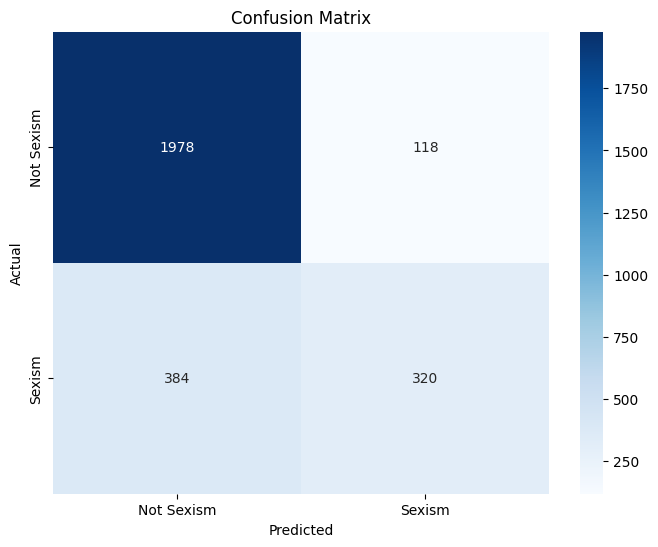

In [62]:
# After training, make predictions on test data
y_pred = model.predict(X_test_indices)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(Y_test_onehot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Define labels for the matrix
labels = ['Not Sexism', 'Sexism']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [64]:
loss = history.history['loss']
accuracy = history.history['accuracy']
precision = history.history['precision']  #'precision' might be changed when running so please change form trainned epoch Sir
recall = history.history['recall'] #'recall' might be changed when running so please change form trainned epoch Sir

f1score = 2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1])

# Print the F1 score and loss
print("Training Loss:", loss[-1])
print("Training Accuracy:", accuracy[-1])
print("Training F1 Score:", f1score)

Training Loss: 0.024002010002732277
Training Accuracy: 0.9923214316368103
Training F1 Score: 0.9923214316368103


In [65]:
loss, accuracy, precision, recall = model.evaluate(X_test_indices, Y_test_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

f1score = 2 * (precision * recall) / (precision + recall)
print("Test F1 Score:",f1score)

88/88 [==============================] - 1s 10ms/step - loss: 0.4144 - accuracy: 0.8207 - precision_2: 0.8207 - recall_2: 0.8207
Test Loss: 0.4143952429294586
Test Accuracy: 0.8207142949104309
Test F1 Score: 0.8207142949104309


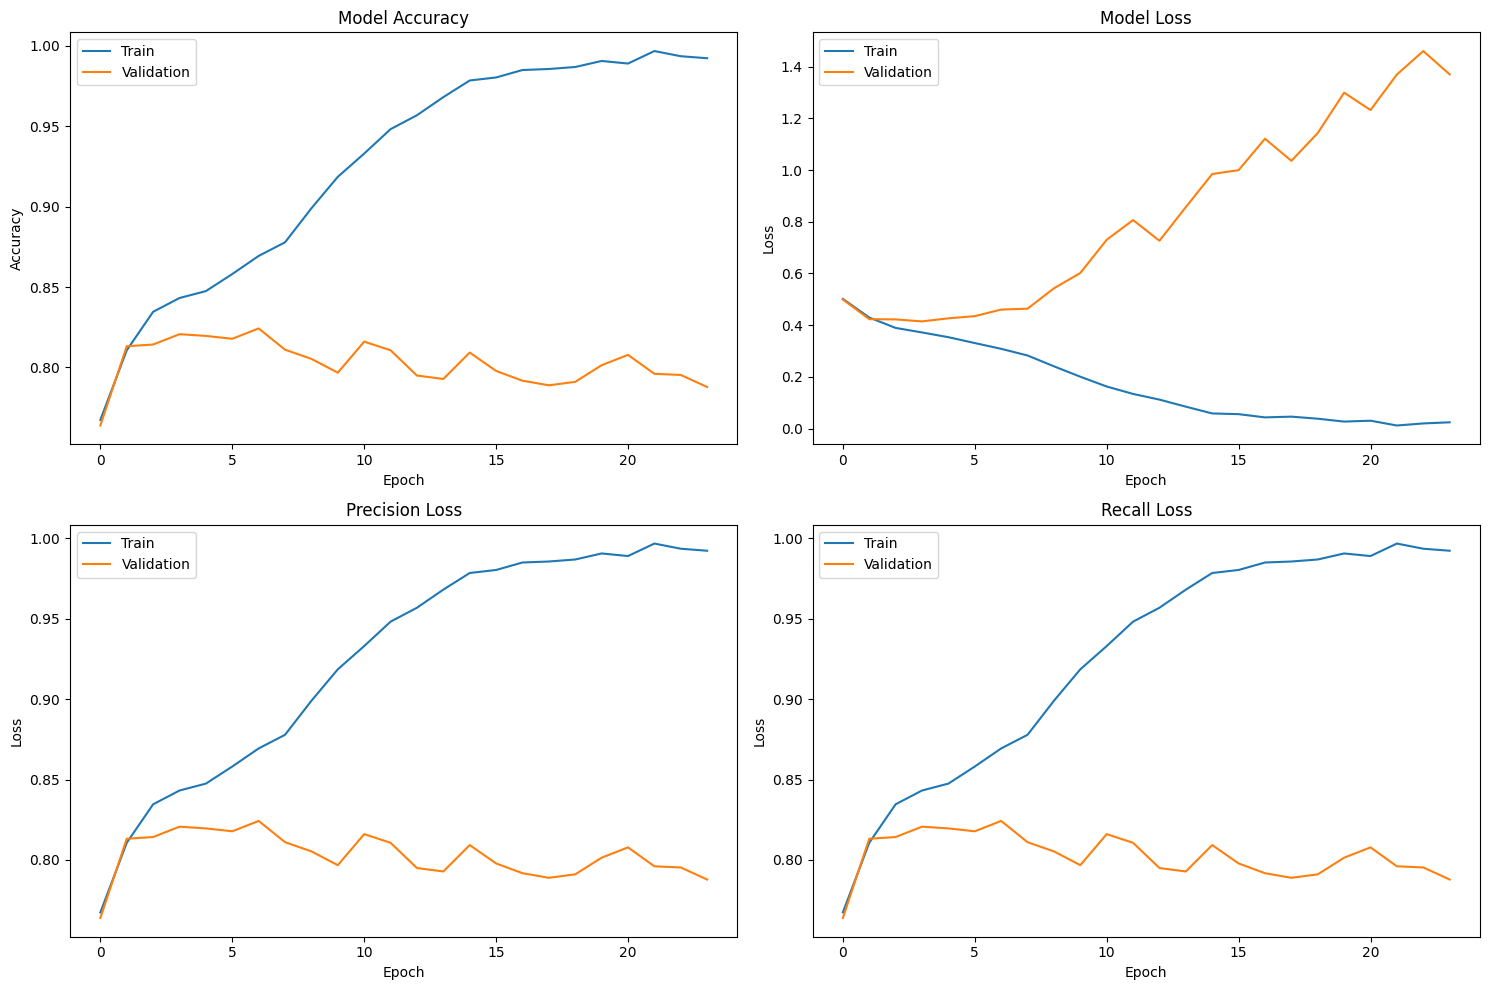

In [66]:
# Plot training and validation curves
plt.figure(figsize=(15, 10))

# Plot training & validation accuracy values
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Task - B (4 Class Classification:  Threats,  Derogation, Animosity, Prejudiced discussions)

In [67]:
df2 = df
df2['text'] = df2['text'].apply(preprocess_text)
df2 = df2[df2['label_category'] != 'none']
df2.head()

,rewire_id,text,label_sexist,label_category,label_vector
8,sexism2022_english-10142,inside wallet cash bank cards credit cards deb...,sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
11,sexism2022_english-760,get initial chance attractive women flock see ...,sexist,2. derogation,2.1 descriptive attacks
17,sexism2022_english-1108,ugly chicks pussy pussy,sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
18,sexism2022_english-10099,fuck nine mm get arab fucks monkey,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm
19,sexism2022_english-10014,talk shit idiot like nazi like bitch,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,..."


In [68]:
df2.shape

(3398, 5)

In [69]:
X2 = []
sentences = list(df2['text'])
for sen in sentences:
    X2.append(sen)

In [70]:
pre_Y = df2['label_category']
label_mapping = {"1. threats, plans to harm and incitement": 0, "2. derogation": 1, "3. animosity": 2, "4. prejudiced discussions": 3}
Y = np.array(list(map(lambda x: label_mapping.get(x), pre_Y)))

In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.20, random_state=42)

In [72]:
maxlen2 = 31
word_to_index = {word: i + 1 for i, word in enumerate(glove_embeddings.keys())}

embedding_dim = len(next(iter(glove_embeddings.values())))
vocab_size = len(word_to_index) + 1  # Add 1 for unknown words
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Example LSTM model
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen2, trainable=False))
model2.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model2.add(Bidirectional(LSTM(units=64)))
model2.add(Dropout(0.25))
model2.add(Dense(units=4, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Print model summary
model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 100)           40000100  
                                                                 
 bidirectional_6 (Bidirecti  (None, 31, 256)           234496    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 40399464 (154.11 MB)
Trainable params: 3

In [73]:
def tokenizer(text):
    return word_tokenize(text)

# Convert text data to sequences of word indices

X_train_indices = [[word_to_index.get(word, 0) for word in tokenizer(sentence)] for sentence in X_train2]
X_test_indices = [[word_to_index.get(word, 0) for word in tokenizer(sentence)] for sentence in X_test2]

# Pad sequences to have the same length
max_len = max(len(seq) for seq in X_train_indices + X_test_indices)
X_train_indices = pad_sequences(X_train_indices, maxlen=max_len)
X_test_indices = pad_sequences(X_test_indices, maxlen=max_len)

# Convert output labels to one-hot encoding
num_classes = len(set(Y))
Y_train_onehot = tf.keras.utils.to_categorical(y_train2, num_classes)
Y_test_onehot = tf.keras.utils.to_categorical(y_test2, num_classes)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history2 = model2.fit(
    X_train_indices, Y_train_onehot,
    validation_data=(X_test_indices, Y_test_onehot),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
43/43 [==============================] - 12s 112ms/step - loss: 1.1585 - accuracy: 0.4551 - precision_3: 0.4976 - recall_3: 0.1534 - val_loss: 1.0846 - val_accuracy: 0.5029 - val_precision_3: 0.5572 - val_recall_3: 0.2794
Epoch 2/100
43/43 [==============================] - 2s 44ms/step - loss: 1.0654 - accuracy: 0.4812 - precision_3: 0.5549 - recall_3: 0.2528 - val_loss: 1.0214 - val_accuracy: 0.5324 - val_precision_3: 0.5876 - val_recall_3: 0.3059
Epoch 3/100
43/43 [==============================] - 2s 41ms/step - loss: 1.0061 - accuracy: 0.5261 - precision_3: 0.5938 - recall_3: 0.3190 - val_loss: 1.0286 - val_accuracy: 0.5176 - val_precision_3: 0.5812 - val_recall_3: 0.3632
Epoch 4/100
43/43 [==============================] - 2s 44ms/step - loss: 0.9587 - accuracy: 0.5644 - precision_3: 0.6365 - recall_3: 0.3955 - val_loss: 0.9985 - val_accuracy: 0.5559 - val_precision_3: 0.5927 - val_recall_3: 0.4324
Epoch 5/100
43/43 [==============================] - 1s 33ms/step - lo

22/22 [==============================] - 2s 7ms/step


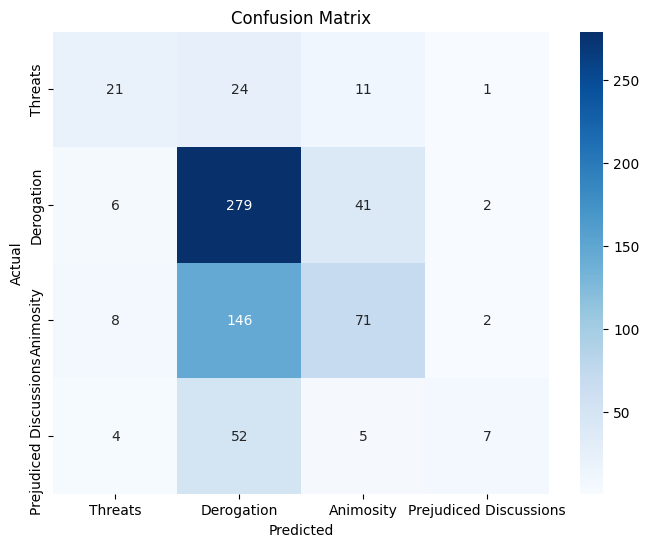

In [74]:
# After training, make predictions on test data
y_pred = model2.predict(X_test_indices)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(Y_test_onehot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Define labels for the matrix
labels = ['Threats', 'Derogation','Animosity','Prejudiced Discussions']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [75]:
loss = history2.history['loss']
accuracy = history2.history['accuracy']
precision = history2.history['precision_1']  #'precision_1' might be changed when running so please change form trainned epoch Sir
recall = history2.history['recall_1'] #'recall_1' might be changed when running so please change form trainned epoch Sir

f1score = 2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1])

# Print the F1 score and loss
print("Training Loss:", loss[-1])
print("Training Accuracy:", accuracy[-1])
print("Training F1 Score:", f1score)

Training Loss: 0.0755770206451416
Training Accuracy: 0.9786607623100281
Training F1 Score: 0.9778679680564717


In [76]:
loss, accuracy, precision, recall = model2.evaluate(X_test_indices, Y_test_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

f1score = 2 * (precision * recall) / (precision + recall)
print("Test F1 Score:",f1score)

22/22 [==============================] - 0s 11ms/step - loss: 0.9985 - accuracy: 0.5559 - precision_3: 0.5927 - recall_3: 0.4324
Test Loss: 0.9985322952270508
Test Accuracy: 0.5558823347091675
Test F1 Score: 0.4999999824708446


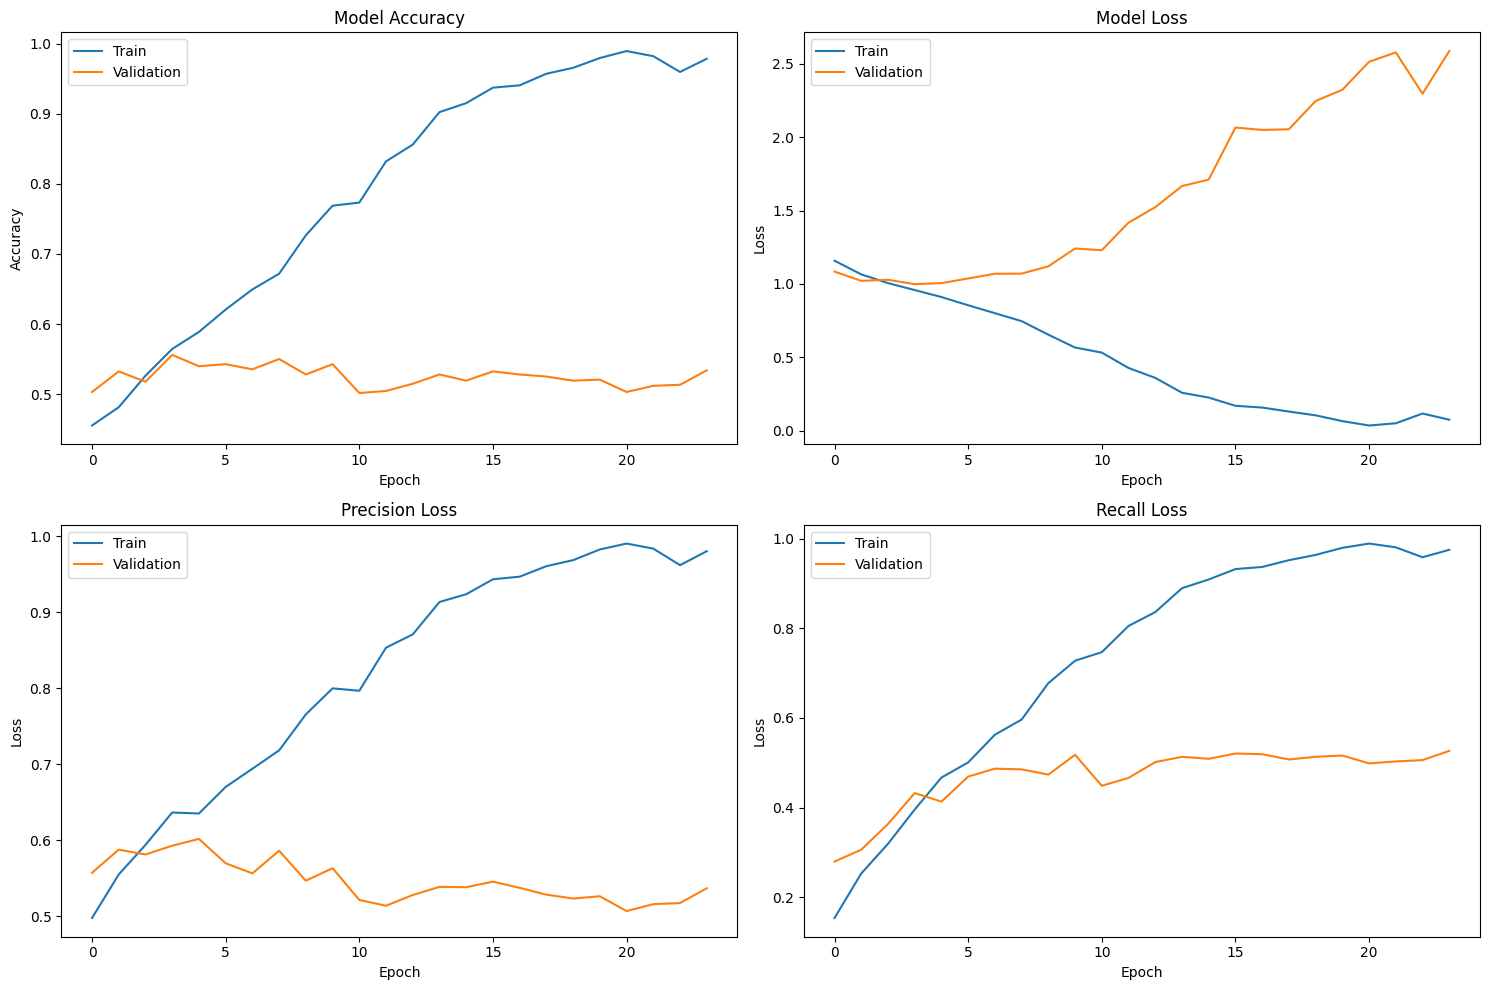

In [77]:
# Plot training and validation curves
plt.figure(figsize=(15, 10))

# Plot training & validation accuracy values
plt.subplot(2, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history2.history['precision_1'])
plt.plot(history2.history['val_precision_1'])
plt.title('Precision Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history2.history['recall_1'])
plt.plot(history2.history['val_recall_1'])
plt.title('Recall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()